# 9. 임베딩 내 편향성 알아보기 [프로젝트]
<br>

## 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기
<br>

#### 사용할 라이브러리 버전 확인
<br>

In [1]:
import konlpy
import gensim
import sklearn
import seaborn

In [2]:
print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


<br>

### STEP 1. 형태소 분석기를 이용해 품사가 명사인 해당 단어 추출하기
<br>

#### 데이터 불러오기 및 확인
<br>

In [3]:
# synopsis.txt의 일부 읽기

In [4]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


<br>

#### konlpy 패키지 이용해 품사가 명사인 단어만 추출
<br>

In [5]:
# konlpy 패키지 설치
# pip install konlpy

<br>

In [6]:
# synopsis.txt 파일을 읽어 품사가 명사인 단어 tokenized에 저장

In [7]:
from konlpy.tag import Okt

okt = Okt()
tokenized = []    # corpus 저장
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      
                res.append(w[0])  # 명사일 때만 tokenized 에 저장됨.
        tokenized.append(res)

In [8]:
print(len(tokenized))

71156


<br><br>

### STEP 2. 추출된 결과로 embedding model 만들기
<br>

In [9]:
# tokenized에 담긴 데이터를 가지고 Word2Vec 생성 (Gensim 4.0 기준)

In [10]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0) 

<br>

In [11]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7149540781974792),
 ('이별', 0.7083982825279236),
 ('애정', 0.7080848813056946),
 ('첫사랑', 0.707859218120575),
 ('만남', 0.7029332518577576),
 ('윌링턴', 0.6989762783050537),
 ('감정', 0.6839667558670044),
 ('진심', 0.6820851564407349),
 ('우정', 0.6753637194633484),
 ('가슴', 0.6734452843666077)]

In [12]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9039223790168762),
 ('영감', 0.8948873281478882),
 ('시나리오', 0.889683723449707),
 ('예술가', 0.8790896534919739),
 ('대본', 0.8742498159408569),
 ('데뷔', 0.8733199834823608),
 ('오페라', 0.8731769323348999),
 ('각색', 0.8711932301521301),
 ('캐스팅', 0.8705601096153259),
 ('시대극', 0.8676618933677673)]

In [13]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8921875953674316),
 ('다큐멘터리', 0.8518356084823608),
 ('드라마', 0.8108214735984802),
 ('형식', 0.7848387956619263),
 ('영화로', 0.783526599407196),
 ('주제', 0.7780449390411377),
 ('편의', 0.7701227068901062),
 ('코미디', 0.7685763835906982),
 ('소재', 0.7683373093605042),
 ('소설', 0.7649245262145996)]

<br><br>

### STEP 3. target, attribute 단어 셋 만들기
<br>

#### target 단어 셋 생성
<br>

In [14]:
# WEAT score를 구하기 위한 단어 셋 생성
# target X, Y 와 attribute A, B, ...

In [15]:
# 영화 장르와 영화 구분 정보를 이용
# target: 영화 구분(예술, 일반)
# attribute: 영화 장르(SF, family, show, horror, ...)

<br>

In [16]:
# 'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 
# 명사에 대해서만 추출하여 art, gen 변수에 할당

In [17]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

In [18]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [19]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [20]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [21]:
print(len(art))
print(len(gen))

620208
3014815


<br>

####  TF-IDF로 해당 데이터의 단어 셋 만들기
<br>

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [23]:
print(X.shape)

(2, 41082)


In [24]:
vectorizer.vocabulary_

{'사운드': 16393,
 '엔지니어': 23276,
 '상우': 16979,
 '유지태': 26211,
 '치매': 33282,
 '할머니': 38818,
 '백성희': 13570,
 '시절': 20436,
 '상처': 17008,
 '아버지': 21403,
 '박인환': 12890,
 '고모': 1682,
 '신신애': 20672,
 '겨울': 1222,
 '지방': 31138,
 '방송국': 13322,
 '라디오': 8220,
 '은수': 26500,
 '이영애': 27166,
 '자연': 28257,
 '소리': 18416,
 '채집': 32086,
 '프로그램': 37858,
 '준비': 30736,
 '녹음': 5484,
 '여행': 23506,
 '사람': 16216,
 '아파트': 21710,
 '사랑': 16220,
 '주체': 30677,
 '정도': 29522,
 '그녀': 3181,
 '만난': 10186,
 '관계': 2277,
 '지나': 31076,
 '여름': 23409,
 '맞이': 10427,
 '삐걱': 16137,
 '린다': 9634,
 '이혼': 27421,
 '경험': 1499,
 '결혼': 1343,
 '생각': 17158,
 '표정': 37613,
 '내비': 5066,
 '단호': 6194,
 '사실': 16351,
 '어찌': 22865,
 '미련': 12114,
 '집착': 31636,
 '감정': 489,
 '이기': 26799,
 '서울': 17533,
 '강릉': 584,
 '간다': 337,
 '태희': 35454,
 '배두나': 13436,
 '깍쟁이': 4277,
 '혜주': 39791,
 '이요원': 27184,
 '그림': 3286,
 '지영': 31198,
 '쌍둥이': 21077,
 '비류': 15681,
 '이은실': 27218,
 '온조': 24568,
 '이은주': 27220,
 '단짝': 6173,
 '친구': 33358,
 '스무': 19590,
 '살이': 16754,
 '길이'

In [25]:
print(vectorizer.vocabulary_['자살'])
print(vectorizer.get_feature_names()[28230])

28230
자살


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<br>

In [26]:
m1 = X[0].tocoo()  # art를 TF-IDF로 표현한 sparse matrix를 가져옴.
m2 = X[1].tocoo()  # gen을 TF-IDF로 표현한 sparse matrix를 가져옴.

In [27]:
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

In [28]:
w1.sort(key=lambda x: x[1], reverse=True)  # art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬 
w2.sort(key=lambda x: x[1], reverse=True)  # gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬 

<br>

In [29]:
print('예술 영화를 대표하는 단어들:')
for i in range(200):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

예술 영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 매력, 프랑스, 사회, 제안, 만남, 무엇, 거리, 이유, 파리, 여성, 정체, 매일, 바로, 시절, 보고, 진실, 홀로, 혼란, 배우, 선택, 다큐멘터리, 혼자, 작가, 갑자기, 일본, 고향, 마주, 도착, 병원, 문제, 로부터, 노래, 주인공, 자리, 대해, 미래, 갈등, 소식, 공연, 서울, 할아버지, 부부, 도움, 연애, 회사, 여자친구, 조직, 소개, 낯선, 찾기, 애인, 잠시, 당신, 고백, 역시, 아무, 시골, 동료, 편지, 촬영, 과정, 영국, 오늘, 마침내, 지구, 마치, 자살, 뉴욕, 탈출, 무대, 주변, 학생, 열정, 발생, 고양이, 고민, 천재, 첫사랑, 더욱, 납치, 약속, 복수, 역사, 의문, 동네, 행복, 파티, 현재, 달리, 여정, 전설, 

In [30]:
print('일반 영화를 대표하는 단어들:')
for i in range(200):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

일반 영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 이후, 조직, 회사, 보고, 부산, 아빠, 부부, 일본, 문제, 처음, 그것, 로부터, 독립, 운명, 감정, 음악, 경쟁, 무엇, 할머니, 결심, 거리, 누구, 혼자, 시절, 준비, 이상, 동료, 만난, 갑자기, 목숨, 과정, 소리, 부천, 이름, 제안, 여인, 지금, 도움, 살해, 역시, 현장, 지구, 촬영, 자기, 페스티벌, 발생, 그린, 이유, 사진, 도착, 자리, 미래, 복수, 학생, 환경, 매일, 경험, 지역, 다큐, 충격, 카메라, 공간, 행동, 중국, 또한, 선택, 방법, 공포, 영상, 대학, 납치, 상처, 배우, 판타스틱, 유혹, 병원, 인물, 상상, 애인, 노인, 할아버지, 공격, 가게, 대신, 게임, 위협, 연인, 매력, 변화, 형사, 고민, 고향, 진실, 노력, 전화, 잠시, 희망, 아무, 홀로, 현재, 

<br>

#### 중복된 단어 제외 및 대표 단어 추출(20개씩)
<br>

In [31]:
# 우선 상위 200개의 단어들 중 중복되는 단어를 제외하고
# 상위 n(=20)개의 단어를 추출합니다.

In [32]:
n = 20
w1_, w2_ = [], []

In [33]:
for i in range(200):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

In [34]:
# w1에만 있고 w2에는 없는, 예술 영화를 잘 대표하는 단어 20개 추출
target_art, target_gen = [], []
for i in range(200):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

In [35]:
# w2에만 있고 w1에는 없는, 일반 영화를 잘 대표하는 단어를 20개 추출
for i in range(200):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [36]:
print(len(w1_))
print(len(w2_))

200
200


<br>

In [37]:
# 추출 단어 확인

In [38]:
print(target_art)

['청년', '프랑스', '만남', '파리', '혼란', '작가', '마주', '노래', '갈등', '소식', '공연', '연애', '여자친구', '소개', '낯선', '찾기', '당신', '고백', '시골', '편지']


In [39]:
print(target_gen)

['애니메이션', '연출', '부문', '섹스', '의도', '부산', '그것', '독립', '경쟁', '소리', '부천', '살해', '현장', '자기', '페스티벌', '사진', '환경', '경험', '지역', '다큐']


<br>

#### attribute 단어 셋 생성
<br>

In [40]:
# 장르별 대표 단어(드라마, 액션) 추출

In [41]:
genre_txt = [
    'synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
    'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
    'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
    'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
    'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt'
]

In [42]:
genre_name = [
    'SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
    '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지'
]

In [43]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [44]:
print(len(genre))

21


<br>

#### TF-IDF로 해당 데이터의 단어 셋 만들기
<br>

In [45]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

In [46]:
print(X.shape)

(21, 42191)


In [47]:
vectorizer.vocabulary_

{'시간': 20740,
 '지명': 31911,
 '한국': 39665,
 '가상': 136,
 '도시': 7247,
 '산성비': 17053,
 '오염': 24957,
 '기억': 3789,
 '망각': 10644,
 '바이러스': 13046,
 '존재': 31072,
 '소문': 18906,
 '시작': 20947,
 '위해': 26528,
 '사람': 16635,
 '두운': 7806,
 '안나': 22350,
 '역시': 24138,
 '그녀': 3245,
 '가이드': 210,
 '유키': 26906,
 '고아': 1789,
 '출신': 33904,
 '여행사': 24104,
 '소속': 18939,
 '택시': 36373,
 '운전사': 26021,
 '나비': 4696,
 '지역': 31976,
 '인도': 28182,
 '정보': 30308,
 '위험': 26530,
 '무릅쓰': 11900,
 '도착': 7313,
 '공사': 2104,
 '현장': 40692,
 '또한': 8338,
 '구슬': 2772,
 '소리': 18886,
 '분위기': 15559,
 '자신': 28946,
 '환각': 41413,
 '한편': 39817,
 '납중독': 5112,
 '상태': 17467,
 '임신': 28644,
 '개월': 817,
 '아이': 22061,
 '하나': 39352,
 '인연': 28298,
 '노출': 5572,
 '정성껏': 30345,
 '캡슐': 34776,
 '하우스': 39490,
 '영상': 24484,
 '누군가': 5756,
 '바랬던': 12939,
 '소녀': 18836,
 '셀프': 18749,
 '비디오': 16074,
 '바이': 13044,
 '여권': 23976,
 '간직': 387,
 '돌진': 7510,
 '유케': 26899,
 '우정': 25917,
 '평소': 38200,
 '사이': 16830,
 '신고': 21089,
 '환자': 41457,
 '격리': 1259,
 '둘이서': 7818,
 

In [48]:
print(vectorizer.vocabulary_['자살'])
print(vectorizer.get_feature_names()[28230])

28926
인민해방군


<br>

In [49]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [50]:
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

<br>

In [51]:
print('SF 장르를 대표하는 단어들:')
for i in range(200):
    print(vectorizer.get_feature_names()[w[0][i][0]], end=', ')

SF 장르를 대표하는 단어들:
위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 한편, 실험, 능력, 시스템, 위협, 생명체, 정부, 아들, 사고, 스타크, 리플리, 과학자, 음모, 파괴, 아버지, 켈빈, 컨트, 모두, 수퍼맨, 임무, 발생, 가족, 요원, 죽음, 다시, 위기, 과거, 외계인, 도시, 이제, 갑자기, 상황, 운명, 분파, 불명, 연구, 개발, 때문, 탈출, 명의, 의문, 남자, 아이, 현실, 바이러스, 상어, 물체, 진화, 목숨, 최후, 통해, 프로젝트, 수트, 생존, 과연, 사랑, 히노키, 섹터, 미국, 여행, 대원, 멸망, 조직, 바로, 위험, 사이, 세력, 감염, 괴물, 거대, 계속, 이상, 마을, 다른, 대한, 이자, 하나, 유성, 무기, 일본, 토니, 슈퍼, 통제, 아내, 데이빗, 토네이도, 상태, 모습, 거미, 최고, 계획, 점점, 군단, 무차별, 공룡, 생각, 로부터, 혼란, 살인, 소녀, 치티, 라임, 에일리언, 강두, 영건, 미노스, 범죄, 돌연변이, 유전자, 주인공, 순간, 도움, 동료, 더욱, 마지막, 조사, 추적, 게임, 운석, 지배, 마토, 지능, 생물체, 영화제, 공포, 방법, 물질, 어둠, 회사, 탐사, 특수, 간다, 가장, 국제, 송현, 앤더, 디셉티콘, 도니, 진행, 경찰, 아이언맨, 시도, 이동, 뉴욕, 폭발, 위저드, 블랙옥스, 인공, 사투, 에너지, 이용, 이야기, 마침내, 초능력, 천재, 희망, 스카이, 기지, 감옥, 괴생명체, 화산, 전투, 찾기, 이유, 감정, 도착, 레아, 등장, 현상, 컴퓨터, 

<br>

#### 중복된 단어 제외 및 대표 단어 추출(20개씩)
<br>

In [52]:
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 20):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 아이, 민혁, 사실, 의문, 미스터리, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 수사, 발견, 한길수, 범인, 계획, 
사극: 조

<br><br>

### STEP 4. WEAT score 계산과 시각화
<br>

#### 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score 계산
<br>

In [53]:
# 코사인 유사도
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [54]:
# attribute A, B 간의 유사도 
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B 

In [55]:
# WEAT score 계산 식
def weat_score(X, Y, A, B):    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

<br>

In [56]:
# 추출한 단어 셋을 21x21 매트릭스 형태로 표현

In [57]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [58]:
shape = (len(genre_name), len(genre_name))
print(shape)

(21, 21)


In [59]:
matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

<br>

In [60]:
# target과 attribute 값 채우기

In [61]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

In [62]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [63]:
print(X.shape)
print(Y.shape)
print(A.shape)
print(B.shape)

(20, 100)
(20, 100)
(20, 100)
(20, 100)


In [64]:
shape = (len(genre_name), len(genre_name))
print(shape)

(21, 21)


In [65]:
matrix

[[0,
  -0.92028713,
  -0.43617484,
  -0.84873,
  0.029581234,
  0.15611617,
  -0.6276135,
  -0.92412406,
  0.016711935,
  -0.7801138,
  -0.3162686,
  -0.8060168,
  -0.6966009,
  -0.6981725,
  -0.7616797,
  0.12102438,
  -0.489109,
  -1.1947795,
  0.19864355,
  -0.9290054,
  -0.43040648],
 [0,
  0,
  0.5639568,
  0.18865816,
  0.8688302,
  0.94571203,
  0.6588532,
  -0.5322462,
  0.8649855,
  -0.055899557,
  0.50150573,
  0.5894228,
  0.8372669,
  -0.15362285,
  -0.028431507,
  0.9867746,
  0.5531049,
  0.24915773,
  0.94923264,
  0.18489398,
  0.9465827],
 [0,
  0,
  0,
  -0.20853694,
  0.9088062,
  0.9140019,
  -0.22196537,
  -0.69333833,
  1.0712059,
  -0.30968955,
  0.098853424,
  -0.1752633,
  -0.04883163,
  -0.49291885,
  -0.31464252,
  0.8926633,
  0.058648888,
  -0.31035084,
  0.63774115,
  -0.42469782,
  0.35443455],
 [0,
  0,
  0,
  0,
  0.50194204,
  0.60374665,
  0.16071613,
  -0.70132196,
  0.5029698,
  -0.5035949,
  0.6284635,
  0.20787866,
  0.33020595,
  -0.28365523,
  -

In [66]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.92028713
SF 공연 -0.43617484
SF 공포(호러) -0.84873
SF 기타 0.029581234
SF 다큐멘터리 0.15611617
SF 드라마 -0.6276135
SF 멜로로맨스 -0.92412406
SF 뮤지컬 0.016711935
SF 미스터리 -0.7801138
SF 범죄 -0.3162686
SF 사극 -0.8060168
SF 서부극(웨스턴) -0.6966009
SF 성인물(에로) -0.6981725
SF 스릴러 -0.7616797
SF 애니메이션 0.12102438
SF 액션 -0.489109
SF 어드벤처 -1.1947795
SF 전쟁 0.19864355
SF 코미디 -0.9290054
SF 판타지 -0.43040648
가족 공연 0.5639568
가족 공포(호러) 0.18865816
가족 기타 0.8688302
가족 다큐멘터리 0.94571203
가족 드라마 0.6588532
가족 멜로로맨스 -0.5322462
가족 뮤지컬 0.8649855
가족 미스터리 -0.055899557
가족 범죄 0.50150573
가족 사극 0.5894228
가족 서부극(웨스턴) 0.8372669
가족 성인물(에로) -0.15362285
가족 스릴러 -0.028431507
가족 애니메이션 0.9867746
가족 액션 0.5531049
가족 어드벤처 0.24915773
가족 전쟁 0.94923264
가족 코미디 0.18489398
가족 판타지 0.9465827
공연 공포(호러) -0.20853694
공연 기타 0.9088062
공연 다큐멘터리 0.9140019
공연 드라마 -0.22196537
공연 멜로로맨스 -0.69333833
공연 뮤지컬 1.0712059
공연 미스터리 -0.30968955
공연 범죄 0.098853424
공연 사극 -0.1752633
공연 서부극(웨스턴) -0.04883163
공연 성인물(에로) -0.49291885
공연 스릴러 -0.31464252
공연 애니메이션 0.8926633
공연 액션 0.058648888


<br>

#### WEAT score 결과를 바탕으로 영화 구분과 영화 장르에 따른 편향성 시각화(heatmap)
<br>

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


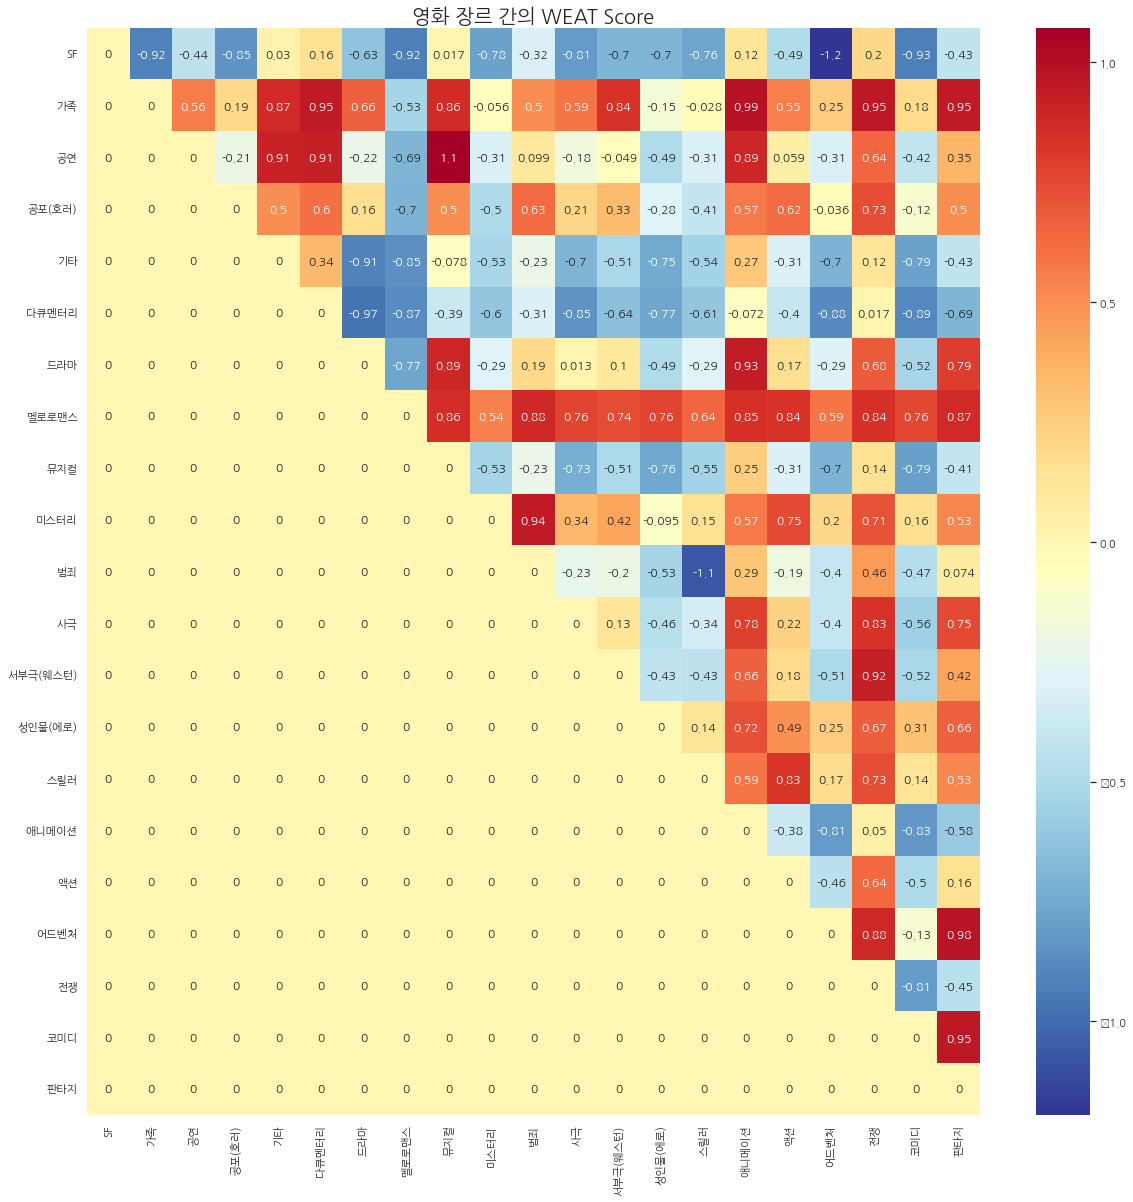

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 히트맵 그리기
plt.figure(figsize=(20,20))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlBu_r')
plt.title('영화 장르 간의 WEAT Score', fontsize=20)
plt.show()

<br>

#### 편향성이 두드러지는 영화장르 attribute 구성의 case 확인
<br>

In [68]:
# WEAT score의 절대값이 큰 경우에 해당 장르들 간의 편향성이 크다고 볼 수 있고,
# 절대값이 크다는 것은 한 장르가 예술 영화나 일반 영화에 편향되어 있다는 것을 의미함.

In [69]:
# 편향성이 큰 장르 조합 찾기
bias_combinations = []
threshold = 0.8  # 임계값 설정

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) > threshold:
            bias_combinations.append((genre_name[i], genre_name[j], matrix[i][j]))

In [70]:
# 편향성이 큰 장르 조합 출력
for comb in bias_combinations:
    print(comb)

('SF', '가족', -0.92028713)
('SF', '공포(호러)', -0.84873)
('SF', '멜로로맨스', -0.92412406)
('SF', '사극', -0.8060168)
('SF', '어드벤처', -1.1947795)
('SF', '코미디', -0.9290054)
('가족', '기타', 0.8688302)
('가족', '다큐멘터리', 0.94571203)
('가족', '뮤지컬', 0.8649855)
('가족', '서부극(웨스턴)', 0.8372669)
('가족', '애니메이션', 0.9867746)
('가족', '전쟁', 0.94923264)
('가족', '판타지', 0.9465827)
('공연', '기타', 0.9088062)
('공연', '다큐멘터리', 0.9140019)
('공연', '뮤지컬', 1.0712059)
('공연', '애니메이션', 0.8926633)
('기타', '드라마', -0.9113135)
('기타', '멜로로맨스', -0.85227907)
('다큐멘터리', '드라마', -0.973446)
('다큐멘터리', '멜로로맨스', -0.8742451)
('다큐멘터리', '사극', -0.84867305)
('다큐멘터리', '어드벤처', -0.8798772)
('다큐멘터리', '코미디', -0.8877405)
('드라마', '뮤지컬', 0.89319116)
('드라마', '애니메이션', 0.93270963)
('멜로로맨스', '뮤지컬', 0.85731286)
('멜로로맨스', '범죄', 0.8782022)
('멜로로맨스', '애니메이션', 0.8450189)
('멜로로맨스', '액션', 0.83883363)
('멜로로맨스', '전쟁', 0.84376675)
('멜로로맨스', '판타지', 0.8687068)
('미스터리', '범죄', 0.94081926)
('범죄', '스릴러', -1.078003)
('사극', '전쟁', 0.833887)
('서부극(웨스턴)', '전쟁', 0.9150667)
('스릴러', '액션', 0.8288

<br>

#### 위 해당 편향성이 큰 조합들만 따로 시각화(heatmap)
<br>

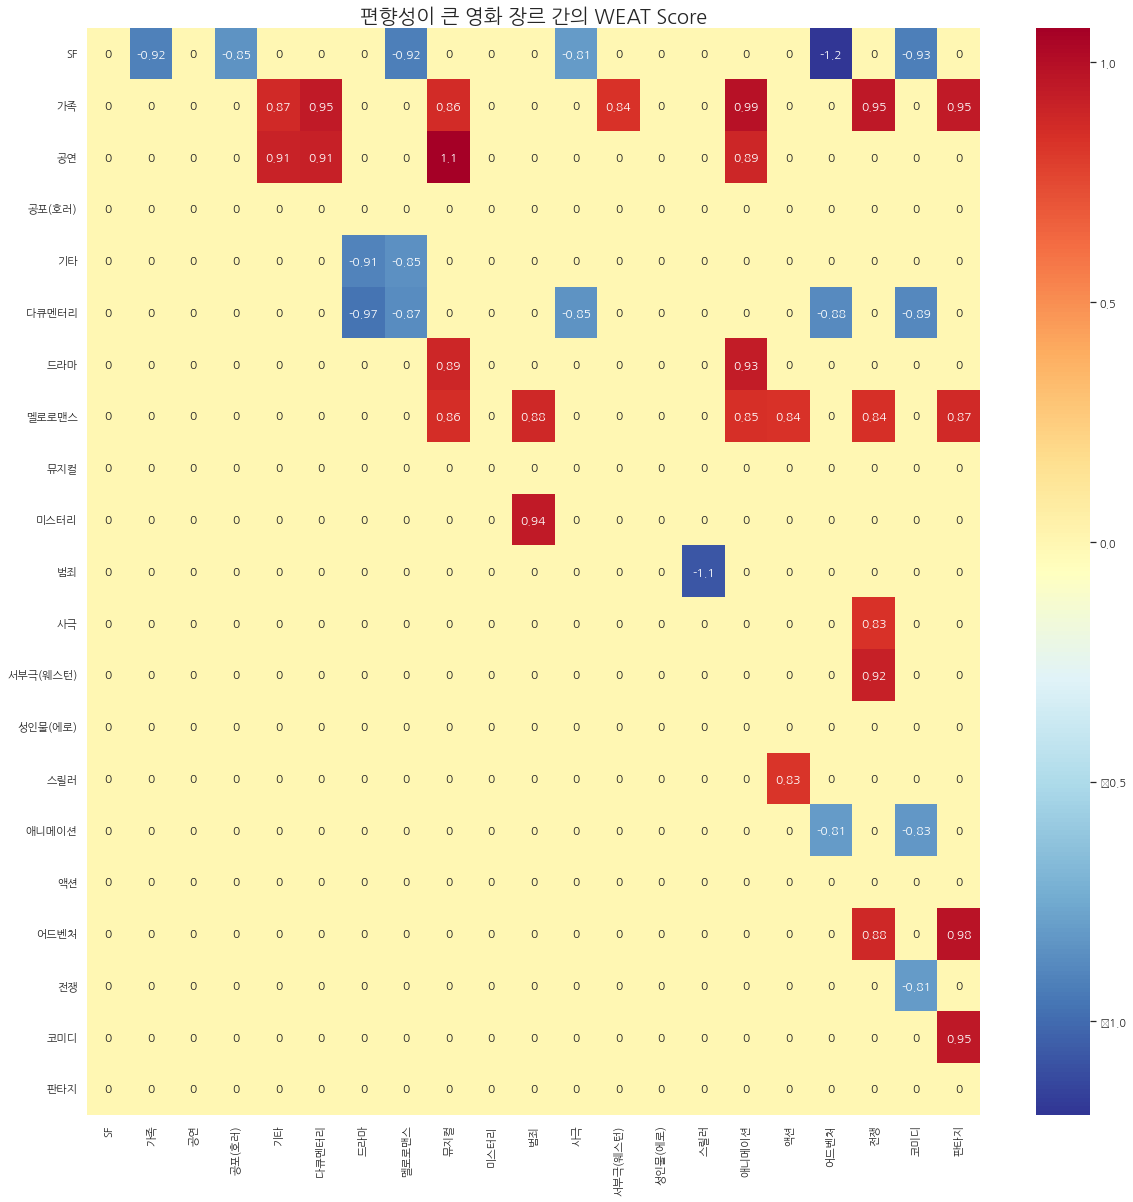

In [71]:
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 편향성이 큰 조합에 대한 히트맵 그리기
bias_matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
for comb in bias_combinations:
    i = genre_name.index(comb[0])
    j = genre_name.index(comb[1])
    bias_matrix[i][j] = comb[2]

plt.figure(figsize=(20,20))
sns.heatmap(bias_matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlBu_r')
plt.title('편향성이 큰 영화 장르 간의 WEAT Score', fontsize=20)
plt.show()

<br><br>

## 9-2. 프로젝트 제출
<br>

### 루브릭

#### 평가문항 및 세부기준

##### 1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.

- 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.

##### 2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
- 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.

##### 3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
- 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.